# ▶ Ejercicio 8.
[Teorema de Bayes] Suponga que tenemos una moneda posiblemente cargada y queremos
inferir su sesgo $p$ = probabilidad de obtener cara.

Se realiza un experimento de:
- $N = 100$ lanzamientos
- $x = 60$ caras
- $N - x = 40$ secas

Queremos:

1. Escribir una función que calcule la distribución **posterior** de $p$ usando:
   - (a) un prior uniforme en $[0,1]$
   - (b) un prior Gaussiano con media 0.5 y desvío 0.1

2. Calcular el **Likelihood** de los datos.

3. Graficar las distribuciones posteriores.

4. Comparar cómo cambia la posterior según la elección del prior.

---

## Recordatorio: Bayes para un parámetro $p$

Sea $p$ la probabilidad de cara en un lanzamiento.

Dado un resultado con:
- $x$ caras
- $N-x$ secas,

el **likelihood** (verosimilitud) como función de $p$ viene dado por un modelo
Binomial:

$$
\mathcal{L}(p) = P(\text{datos} \mid p)
= \binom{N}{x} p^x (1-p)^{N-x}.
$$

El Teorema de Bayes nos dice que la distribución posterior es:

$$
P(p \mid \text{datos}) \propto P(\text{datos} \mid p)\, P(p),
$$

donde $P(p)$ es el prior elegido.

Luego normalizamos para que:
$$
\int_0^1 P(p \mid \text{datos}) \, dp = 1.
$$


In [1]:
# ============================================
# Ejercicio 8 - Configuración inicial
# ============================================

import numpy as np
import matplotlib.pyplot as plt
import math

# Datos del experimento
N = 100       # número total de lanzamientos
x = 60        # número de caras observadas


## Likelihood de los datos

Usamos el modelo Binomial. Definimos una función que, dado un valor de $p$,
devuelve la verosimilitud de observar $x$ caras en $N$ lanzamientos:

$$
\mathcal{L}(p) = \binom{N}{x} p^x (1-p)^{N-x}.
$$

La constante combinatoria $\binom{N}{x}$ es fija para este experimento y solo
escala la curva, pero la incluimos para que la función sea el likelihood completo.


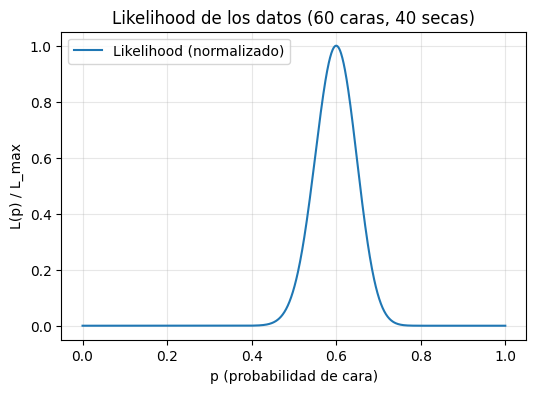

In [2]:
# ============================================
# Likelihood binomial de los datos
# ============================================

def likelihood(p, x, N):
    """
    Calcula la verosimilitud L(p) = P(datos | p) para una Binomial(N, p).

    Parámetros
    ----------
    p : float o array
        Probabilidad de obtener cara.
    x : int
        Número de caras observadas.
    N : int
        Número total de lanzamientos.

    Devuelve
    --------
    L : float o array
        Likelihood evaluado en p.
    """
    # Usamos la combinación exacta para mantener corrección formal
    comb = math.comb(N, x)
    return comb * (p**x) * ((1-p)**(N - x))


# Creamos una grilla de valores posibles de p en [0,1]
p_grid = np.linspace(0, 1, 1000)

L_values = likelihood(p_grid, x, N)

# Graficamos la verosimilitud (normalizada para verla mejor)
plt.figure(figsize=(6,4))
plt.plot(p_grid, L_values / L_values.max(), label="Likelihood (normalizado)")
plt.xlabel("p (probabilidad de cara)")
plt.ylabel("L(p) / L_max")
plt.title("Likelihood de los datos (60 caras, 40 secas)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


## Prior uniforme en $([0,1])$

Tomamos:
$$
P(p) = 1 \quad \text{para } 0 \le p \le 1.
$$

Con este prior, la posterior es proporcional solo al likelihood:

$$
P(p \mid \text{datos}) \propto p^x (1-p)^{N-x}.
$$

Esto es exactamente una **distribución Beta**:

$$
P(p \mid \text{datos}) = \text{Beta}(p \mid \alpha, \beta),
$$

con
$$
\alpha = x + 1, \quad \beta = N - x + 1.
$$

En nuestro caso:
$$
\alpha = 61, \quad \beta = 41.
$$

La media posterior es:
$$
\mathbb{E}[p \mid \text{datos}] = \frac{\alpha}{\alpha + \beta}
= \frac{61}{102} \approx 0.598.
$$

Definimos una función para la PDF de la Beta y graficamos la posterior.


Área bajo la posterior (prior uniforme): 0.9999999999999999


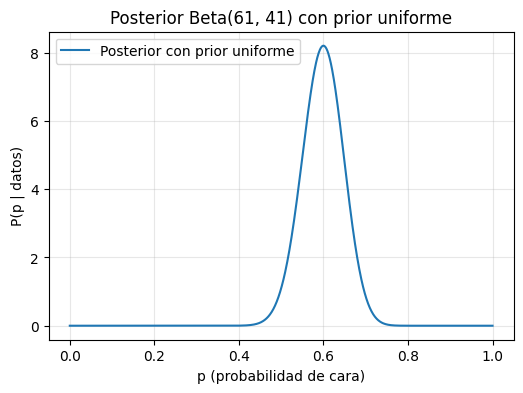

In [4]:
# ============================================
# Posterior con prior uniforme: Beta(61, 41)
# ============================================

def beta_posterior(p, alpha, beta):
    """
    Densidad de una distribución Beta(alpha, beta) evaluada en p.
    Implementada "a mano" usando funciones gamma.
    """
    # Constante de normalización Beta(alpha, beta)
    B = math.gamma(alpha) * math.gamma(beta) / math.gamma(alpha + beta)
    return (p**(alpha - 1)) * ((1 - p)**(beta - 1)) / B


alpha = x + 1          # 61
beta_param = N - x + 1 # 41

posterior_uniform = beta_posterior(p_grid, alpha, beta_param)

# Verificamos que esté normalizada numéricamente
area = np.trapezoid(posterior_uniform, p_grid)
print("Área bajo la posterior (prior uniforme):", area)

# Graficamos la posterior
plt.figure(figsize=(6,4))
plt.plot(p_grid, posterior_uniform, label="Posterior con prior uniforme")
plt.xlabel("p (probabilidad de cara)")
plt.ylabel("P(p | datos)")
plt.title("Posterior Beta(61, 41) con prior uniforme")
plt.grid(alpha=0.3)
plt.legend()
plt.show()


## Prior Gaussiano: $ \mathcal{N}(0.5, \sigma=0.1) $

Ahora suponemos que **antes del experimento** creemos que la moneda es
aproximadamente justa, con:

- media: $\mu = 0.5$
- desvío: $\sigma = 0.1$

Tomamos como prior:
$$
P(p) \propto \exp\left[-\frac{(p - \mu)^2}{2\sigma^2}\right],
$$

y lo consideramos definido en el intervalo $[0,1]$.
(Es decir, fuera de $[0,1]$ su contribución es cero.)

La posterior ahora es:
$$
P(p \mid \text{datos}) \propto \mathcal{L}(p)\, P_{\text{Gauss}}(p).
$$

Como este prior ya no es conjugado con la Binomial, normalizamos la posterior
**numéricamente** sobre la grilla de $p$.


Área bajo la posterior (prior Gaussiano): 0.9999999999999997


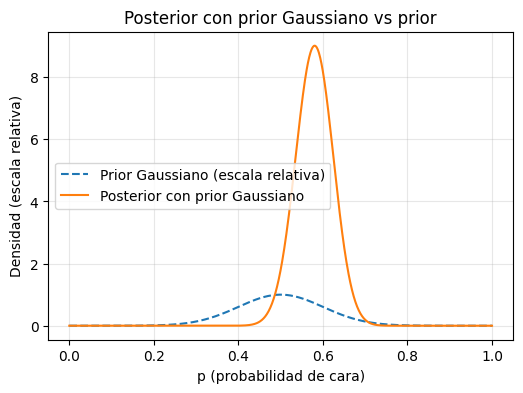

In [6]:
# ============================================
# Prior Gaussiano y posterior numérica
# ============================================

def gaussian_prior(p, mu=0.5, sigma=0.1):
    """
    Prior Gaussiano N(mu, sigma) evaluado en p.
    No se fuerza normalización en [0,1] aquí: usamos la forma estándar.
    """
    return (1.0 / (sigma * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((p - mu) / sigma)**2)


# Calculamos prior Gaussiano en la grilla (y lo anulamos fuera de [0,1] por las dudas numéricas)
prior_g = gaussian_prior(p_grid)
prior_g[(p_grid < 0) | (p_grid > 1)] = 0.0

# Posterior no normalizada: L(p) * prior_g(p)
posterior_g_unnorm = likelihood(p_grid, x, N) * prior_g

# Normalizamos numéricamente
Z = np.trapezoid(posterior_g_unnorm, p_grid)
posterior_g = posterior_g_unnorm / Z

print("Área bajo la posterior (prior Gaussiano):", np.trapezoid(posterior_g, p_grid))

# Graficamos prior Gaussiano (re-escalado) y posterior resultante
plt.figure(figsize=(6,4))
plt.plot(p_grid, prior_g / prior_g.max(), '--', label="Prior Gaussiano (escala relativa)")
plt.plot(p_grid, posterior_g, label="Posterior con prior Gaussiano")
plt.xlabel("p (probabilidad de cara)")
plt.ylabel("Densidad (escala relativa)")
plt.title("Posterior con prior Gaussiano vs prior")
plt.grid(alpha=0.3)
plt.legend()
plt.show()


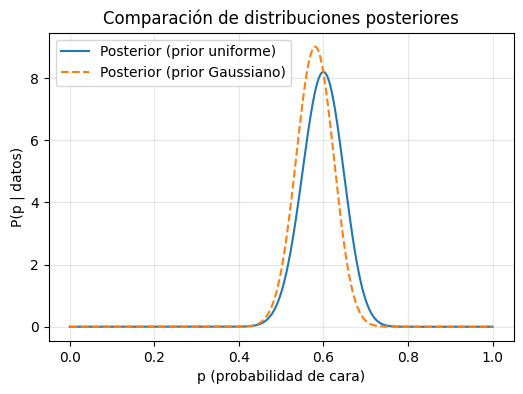

Media posterior (prior uniforme): 0.5980
Media posterior (prior Gaussiano): 0.5795


In [8]:
# ============================================
# Comparación: prior uniforme vs prior Gaussiano
# ============================================

plt.figure(figsize=(6,4))
plt.plot(p_grid, posterior_uniform, label="Posterior (prior uniforme)")
plt.plot(p_grid, posterior_g, label="Posterior (prior Gaussiano)", linestyle="--")
plt.xlabel("p (probabilidad de cara)")
plt.ylabel("P(p | datos)")
plt.title("Comparación de distribuciones posteriores")
plt.grid(alpha=0.3)
plt.legend()
plt.show()

# Cálculo de medias aproximadas para comparar numéricamente
mean_uniform = np.trapezoid(p_grid * posterior_uniform, p_grid)
mean_gauss   = np.trapezoid(p_grid * posterior_g, p_grid)

print(f"Media posterior (prior uniforme): {mean_uniform:.4f}")
print(f"Media posterior (prior Gaussiano): {mean_gauss:.4f}")


## Discusión: efecto de la elección del prior

- Con **prior uniforme**, la información proviene únicamente de los datos:
  la posterior es Beta(61, 41), concentrada alrededor de
  $$ p \approx 0.60, $$
  reflejando fuertemente las 60 caras sobre 100 lanzamientos.

- Con el **prior Gaussiano** centrado en 0.5 (moneda justa) y $\sigma = 0.1$,
  estamos incorporando una creencia previa que "empuja" a $p$ hacia 0.5.
  El resultado es una posterior muy parecida a la del caso uniforme,
  pero con la media ligeramente más cercana a 0.5:
  es decir, el prior tira un poco hacia la moneda justa.

- Como el experimento tiene bastantes datos ($N=100$),
  la evidencia experimental domina sobre el prior,
  y ambas posteriores son relativamente similares.
  Si tuviéramos muchos menos lanzamientos, la elección del prior tendría
  un efecto mucho más fuerte en la forma de la distribución posterior.

Esta comparación ilustra el punto central del enfoque Bayesiano:
la posterior es un compromiso entre la información previa (prior)
y la información contenida en los datos (likelihood).
